In [20]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import distribute
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # без этого не работает

#tf.sysconfig.get_compile_flags()


In [21]:
import pathlib
dataset_url   ="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir   =   tf.keras.utils.get_file('flower_photos',origin=dataset_url, untar=True)


In [22]:
print(data_dir)

C:\Users\drug1\.keras\datasets\flower_photos


In [23]:
data_dir = pathlib.Path(data_dir)
#image_count = len(list(data_dir.glob('*/*.jpg')))
#print(image_count)

In [24]:
#roses = list(data_dir.glob('roses/*'))
#PIL.Image.open(str(roses[0]))


In [25]:
batch_size = 32 # размер порции данных
img_height = 170 # размер картинок
img_width = 170


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [26]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [27]:
print(train_ds)
print(val_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 170, 170, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 170, 170, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [28]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


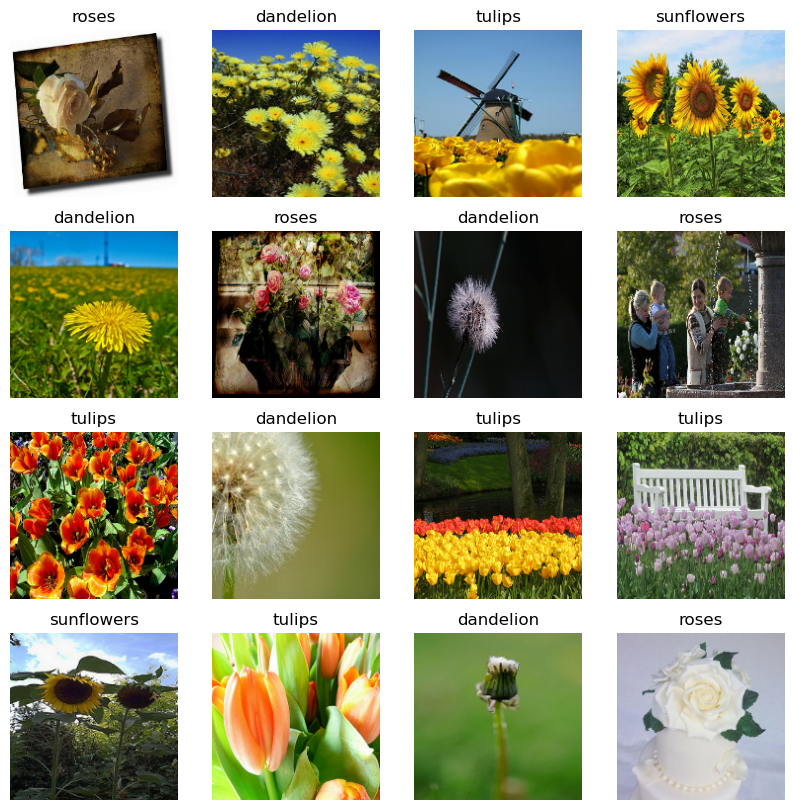

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()


In [36]:
'''
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
''' 

'\nfor image_batch, labels_batch in train_ds:\n  print(image_batch.shape)\n  print(labels_batch.shape)\n  break\n'

In [33]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [42]:
# СТАНДАРТИЗАЦИЯ
normalization_layer = layers.Rescaling(1./255)

'''
normalized_ds = train_ds.map(lambda   x,   y:
(normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

'''

'\nnormalized_ds = train_ds.map(lambda   x,   y:\n(normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(normalized_ds))\nfirst_image = image_batch[0]\n# Notice the pixel values are now in `[0,1]`.\nprint(np.min(first_image), np.max(first_image))\n\n'

In [44]:
# МОДЕЛЬ

num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255,   input_shape=(img_height,   img_width,3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [45]:
# Используем оптимизатор АДАМ (улучшитель градиентного спуска)
# Функция потерь
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 170, 170, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 170, 170, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 85, 85, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 85, 85, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 64)       

In [47]:
# обучение модели

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
92/92 [==============================] - 19s 198ms/step - loss: 1.2885 - accuracy: 0.4496 - val_loss: 1.1445 - val_accuracy: 0.5191
Epoch 2/10
92/92 [==============================] - 18s 192ms/step - loss: 1.0292 - accuracy: 0.5909 - val_loss: 0.9524 - val_accuracy: 0.6063
Epoch 3/10
92/92 [==============================] - 18s 199ms/step - loss: 0.8506 - accuracy: 0.6672 - val_loss: 0.9298 - val_accuracy: 0.6144
Epoch 4/10
92/92 [==============================] - 18s 201ms/step - loss: 0.7232 - accuracy: 0.7309 - val_loss: 0.9065 - val_accuracy: 0.6635
Epoch 5/10
92/92 [==============================] - 18s 196ms/step - loss: 0.5363 - accuracy: 0.8045 - val_loss: 0.9343 - val_accuracy: 0.6403
Epoch 6/10
92/92 [==============================] - 18s 200ms/step - loss: 0.3422 - accuracy: 0.8835 - val_loss: 1.1191 - val_accuracy: 0.6213
Epoch 7/10
92/92 [==============================] - 18s 195ms/step - loss: 0.2196 - accuracy: 0.9268 - val_loss: 1.2606 - val_accuracy: 0.6253

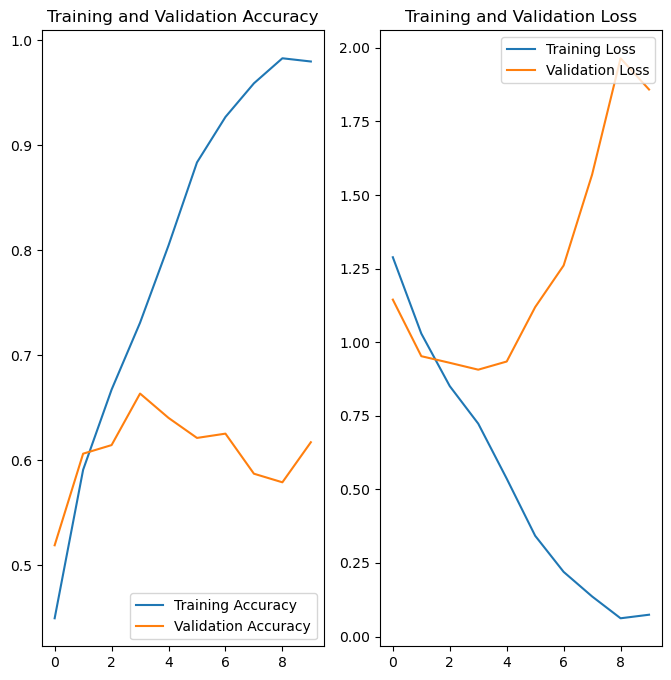

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [71]:
# Расширение данных

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


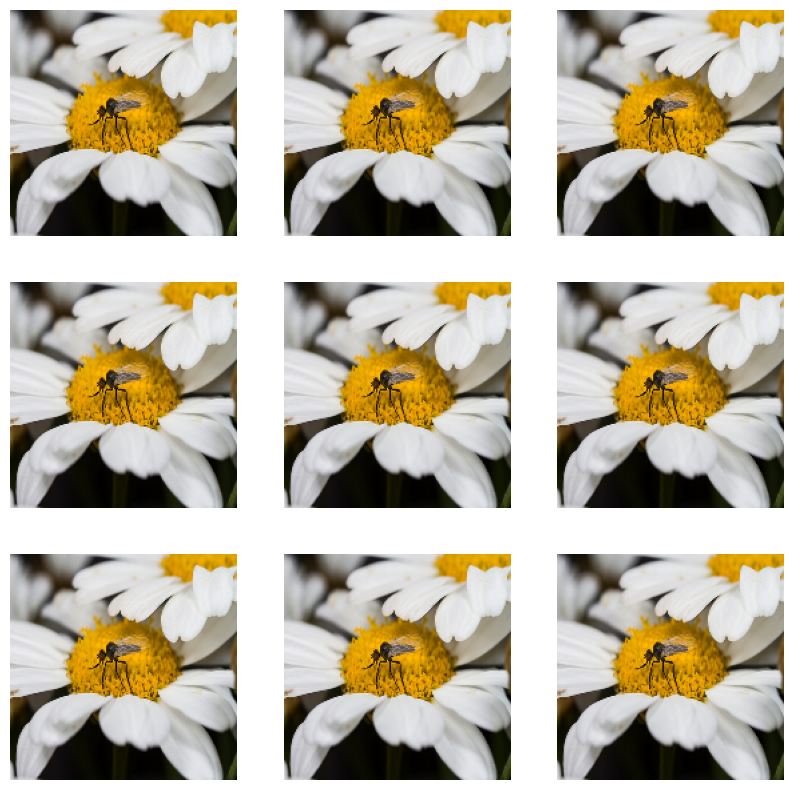

In [72]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [73]:
# ОТСЕВ
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [74]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy
(from_logits=True), metrics=['accuracy'])


In [75]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 170, 170, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 170, 170, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 170, 170, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 85, 85, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 85, 85, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 42, 42, 32)       0         
 g2D)                                                 

In [76]:
# ОБУЧЕНИЕ
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

  

Epoch 1/15
92/92 [==============================] - 22s 225ms/step - loss: 1.2847 - accuracy: 0.4527 - val_loss: 1.0879 - val_accuracy: 0.5613
Epoch 2/15
92/92 [==============================] - 20s 222ms/step - loss: 1.0631 - accuracy: 0.5698 - val_loss: 1.0051 - val_accuracy: 0.5899
Epoch 3/15
92/92 [==============================] - 20s 215ms/step - loss: 0.9542 - accuracy: 0.6270 - val_loss: 1.0077 - val_accuracy: 0.6226
Epoch 4/15
92/92 [==============================] - 20s 214ms/step - loss: 0.8669 - accuracy: 0.6768 - val_loss: 0.9066 - val_accuracy: 0.6362
Epoch 5/15
92/92 [==============================] - 20s 214ms/step - loss: 0.7980 - accuracy: 0.6955 - val_loss: 0.8415 - val_accuracy: 0.6703
Epoch 6/15
92/92 [==============================] - 20s 218ms/step - loss: 0.7806 - accuracy: 0.7044 - val_loss: 0.8823 - val_accuracy: 0.6771
Epoch 7/15
92/92 [==============================] - 20s 220ms/step - loss: 0.7365 - accuracy: 0.7275 - val_loss: 0.7541 - val_accuracy: 0.7153

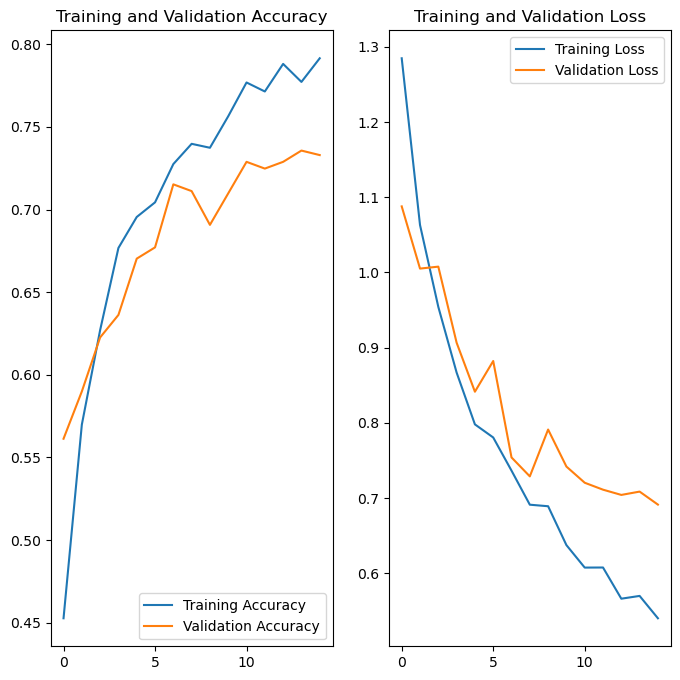

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [82]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path   =   tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)


img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to sunflowers with a 85.21 percent confidence.
